# Intro to CV, DL, and PyTorch (Intro 3: "Intro x3")

In [1]:
import os
from IPython.display import Image as JupyterImage
from typing import Dict, Iterable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
from PIL import Image, ImageOps, ImageChops  # pip install Pillow
from skimage import io, transform  # pip install scikit-image
from torch.nn import CrossEntropyLoss, Module
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [2]:
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working

%config Completer.use_jedi = False

## Classification

* https://en.wikipedia.org/wiki/Precision_and_recall

## "Data"

* https://en.wikipedia.org/wiki/Portable_Network_Graphics
* https://stackoverflow.com/questions/1962795/how-to-get-alpha-value-of-a-png-image-with-pil
* https://matplotlib.org/stable/tutorials/introductory/images.html

In [3]:
! ls

data_original  images  ML3.ipynb


In [4]:
DATA_FOLDER_ORIGINAL = 'data_original'

In [5]:
! ls $DATA_FOLDER_ORIGINAL

circle.png  square.png	triangle.png


In [6]:
TRIANGLE = 'triangle'
SQUARE = 'square'
CIRCLE = 'circle'

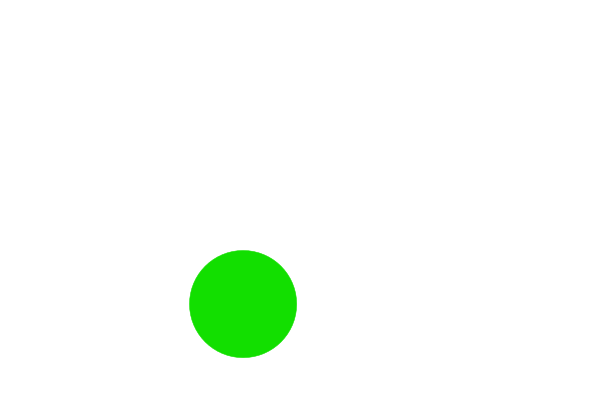

In [7]:
JupyterImage(filename=f'{DATA_FOLDER_ORIGINAL}/{CIRCLE}.png')

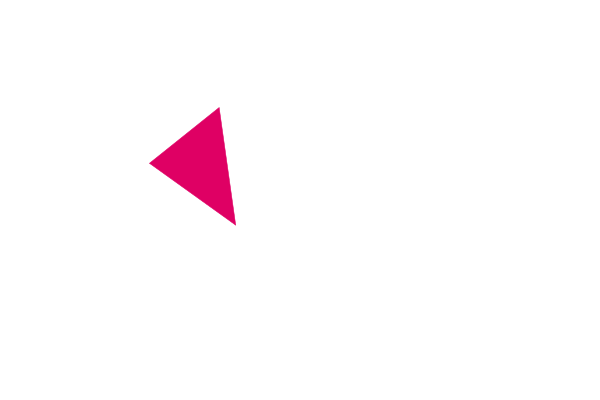

In [8]:
JupyterImage(filename=f'{DATA_FOLDER_ORIGINAL}/{TRIANGLE}.png')

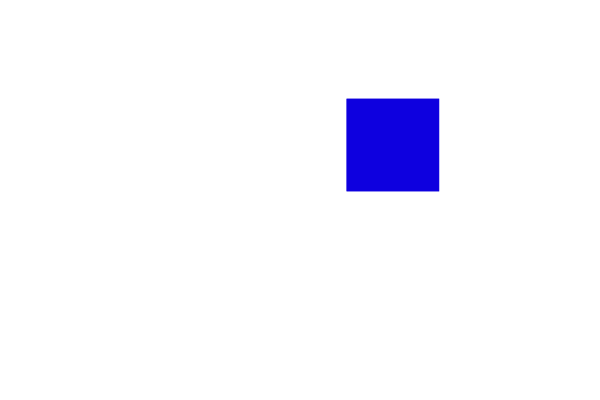

In [9]:
JupyterImage(filename=f'{DATA_FOLDER_ORIGINAL}/{SQUARE}.png')

## Geometric Approach ("Handcrafted ML")

## On the Way to ML: Data Preprocessing

* https://en.wikipedia.org/wiki/Data_augmentation
* https://stackoverflow.com/questions/18777873/convert-rgb-to-black-or-white

### Data Augmentation

In [10]:
# https://www.geeksforgeeks.org/how-to-rotate-an-image-using-python/

original_image = Image.open(f"{DATA_FOLDER_ORIGINAL}/{TRIANGLE}.png")

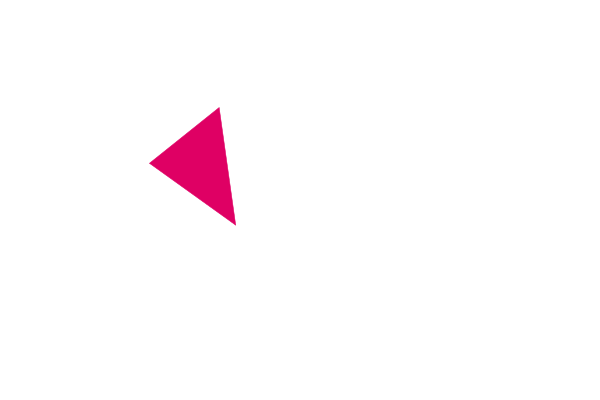

In [11]:
original_image

In [12]:
original_image.size

(600, 400)

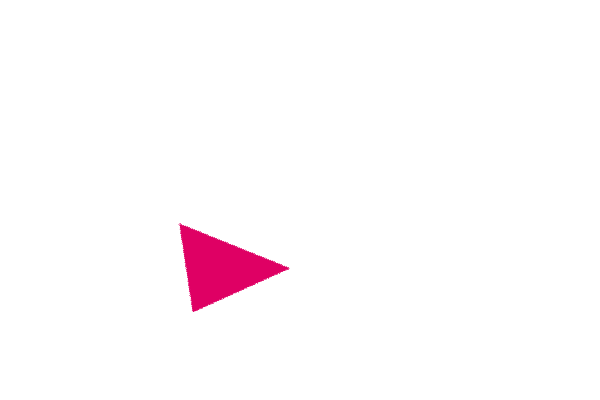

In [13]:
original_image.rotate(60)

In [14]:
original_image.rotate(60).save('rotated_60.png')

In [15]:
! ls

data_original  images  ML3.ipynb  rotated_60.png


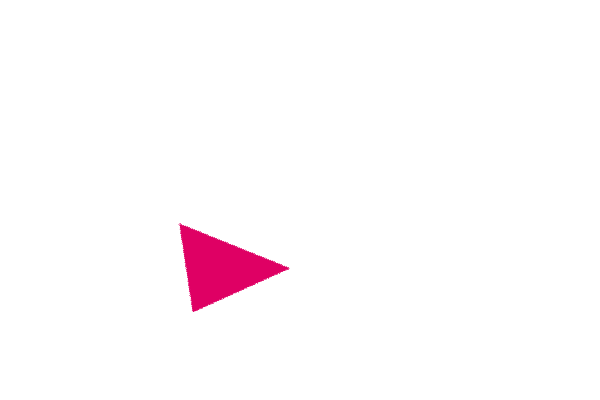

In [16]:
JupyterImage('rotated_60.png')

In [17]:
# http://www.legendu.net/misc/blog/python-pillow-image-shift/

In [18]:
DATA_FOLDER_GENERATED = 'data_generated'

In [19]:
! mkdir $DATA_FOLDER_GENERATED

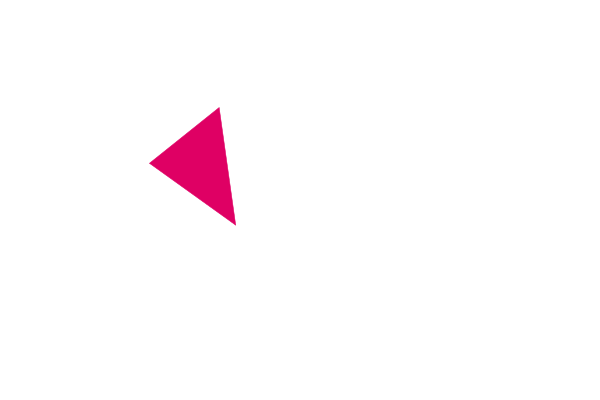

In [20]:
original_image

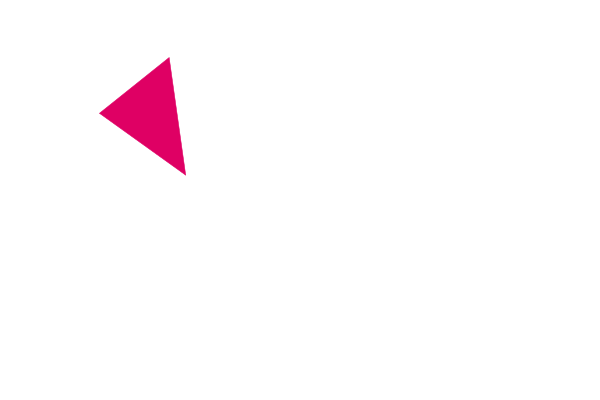

In [21]:
ImageChops.offset(original_image, -50, -50)

In [22]:
os.listdir(DATA_FOLDER_ORIGINAL)

['triangle.png', 'square.png', 'circle.png']

In [23]:
os.path.splitext('square.png')

('square', '.png')

In [24]:
x_shift_range = range(-50, 51, 25)
y_shift_range = range(-50, 51, 25)

_original_image_names = os.listdir(DATA_FOLDER_ORIGINAL)

for image_name in tqdm.tqdm(_original_image_names, total=len(_original_image_names)):
    image_path = os.path.join(DATA_FOLDER_ORIGINAL, image_name)
    original_image = Image.open(image_path)
    
    for x_shift in x_shift_range:
        for y_shift in y_shift_range:
            if CIRCLE in image_name:
                angle_range = [0]
            else:
                angle_range = range(0, 91, 30)
            
            for angle in angle_range:
                image = original_image.rotate(angle)
                image = ImageChops.offset(
                    image, xoffset=x_shift, yoffset=y_shift
                )
                
                basename, extension = os.path.splitext(image_name)
                new_image_name = (
                    f'{basename}'
                    f'__xo_{x_shift}'
                    f'__yo_{y_shift}'
                    f'__ang_{angle}{extension}'
                )
                new_image_path = os.path.join(
                    DATA_FOLDER_GENERATED, new_image_name
                )
                image.save(new_image_path)

100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


In [25]:
! ls data_generated | wc -l

225


In [26]:
! ls data_generated | head

circle__xo_0__yo_0__ang_0.png
circle__xo_0__yo_-25__ang_0.png
circle__xo_0__yo_25__ang_0.png
circle__xo_0__yo_-50__ang_0.png
circle__xo_0__yo_50__ang_0.png
circle__xo_-25__yo_0__ang_0.png
circle__xo_25__yo_0__ang_0.png
circle__xo_-25__yo_-25__ang_0.png
circle__xo_-25__yo_25__ang_0.png
circle__xo_25__yo_-25__ang_0.png


### Dataset

In [27]:
class GeometricShapesDataset(Dataset):
    _LABEL_NAME_TO_ID = {
        'triangle': 0,
        'square': 1,
        'circle': 2,
    }
    _LABEL_ID_TO_NAME = {v: k for k, v in _LABEL_NAME_TO_ID.items()}
    
    def __init__(
            self,
            folder_path: str,
            file_names = None,
            transform=None
            ):
        self._root_folder = folder_path
        self._transform = transform
        
        _file_names = sorted(os.listdir(self._root_folder))
        
        if file_names is not None:
            assert set(file_names) < set(_file_names)
            
            self._file_names = file_names
        else:
            self._file_names = _file_names

    def __len__(self) -> int:
        return len(self._file_names)

    def __getitem__(self, index: int) -> Tuple[np.array, int]:
        file_name = self._file_names[index]
        file_path = os.path.join(self._root_folder, file_name)
        image = io.imread(file_path)
        label_name = file_name.split('__')[0]
        label = self._LABEL_NAME_TO_ID[label_name]

        if self._transform is None:
            sample = image
        else:
            sample = self._transform(image)

        return (sample, label)

In [28]:
dataset = GeometricShapesDataset(folder_path=DATA_FOLDER_GENERATED)

In [29]:
dataset[1][0].shape

(400, 600, 4)

Label ID: 2. Label name: circle.
Image shape: (400, 600, 4)


((array([[[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          ...,
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],
  
         [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          ...,
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],
  
         [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          ...,
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],
  
         ...,
  
         [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          ...,
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],
  
         [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          ...,
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],
  
         [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          ...,
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]], dtype=u

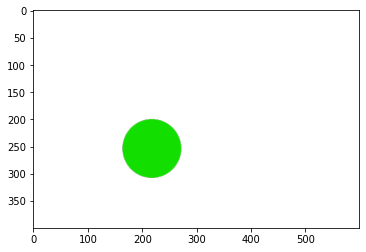

In [30]:
_data_item = dataset[1]
_image, _label = _data_item

print(
    f'Label ID: {_label}.'
    f' Label name: {GeometricShapesDataset._LABEL_ID_TO_NAME[_label]}.'
)

print(f'Image shape: {_image.shape}')

plt.imshow(_image)

_data_item, _image, _label

In [31]:
_image[:, :, -1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [32]:
def to_black_and_white(image: np.array) -> np.array:
    image_one_channel = (
        np.max(
            image[:, :, :3], axis=2, keepdims=True
        )  # * image[:, :, -1:]
    ).astype(int)
    
    image_one_channel[image_one_channel > 0] = 255
    
    return image_one_channel

In [33]:
to_black_and_white(_image)

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])

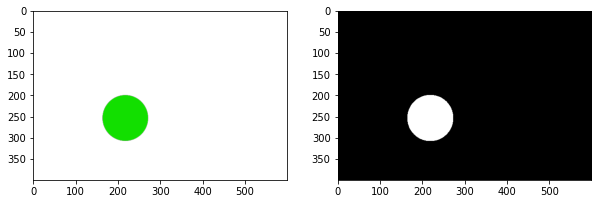

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

_image, _ = dataset[1]

axes[0].imshow(_image)
axes[1].imshow(to_black_and_white(_image), cmap='gray')

plt.show()

## Dummy ML: Image -> "Features" -> Answer

### Intro to Torch

In [35]:
# https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [36]:
a

tensor([2., 3.], requires_grad=True)

In [37]:
b

tensor([6., 4.], requires_grad=True)

$$ Q = 3 a^3 - b^2 $$

In [38]:
Q = 3 * a ** 3 - b ** 2

In [39]:
Q

tensor([-12.,  65.], grad_fn=<SubBackward0>)

In [40]:
Q.sum().backward()

$$ \frac{\partial Q}{\partial a} = 9 a^2, \quad \frac{\partial Q}{\partial b} = -2b^2 $$

In [41]:
assert torch.allclose(a.grad, 9 * a ** 2)
assert torch.allclose(b.grad, -2 * b)

### Handmade Linear Model

In [42]:
class LinearModel1(Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        
        self.weight = nn.Parameter(
            torch.ones(
                size=(out_features, in_features), requires_grad=True
            )
        )
        self.bias = nn.Parameter(
            torch.ones(size=(out_features, 1), requires_grad=True)
        )
    
    def forward(self, input):
        # input: Batch X Width X Height X InChannels
        
        input = input.flatten(1)  # Batch X InFeatures
        input = input.unsqueeze(-1)  # Batch X InFeatures X 1
        
        output = torch.matmul(self.weight, input) + self.bias  # Batch X OutFeatures X 1
        output = output.squeeze(-1)  # Batch X OutFeatures
        
        return output

In [43]:
_image, _ = dataset[0]
_bw_image = to_black_and_white(_image)

model = LinearModel1(in_features=_bw_image.size, out_features=3)

_bw_image = _bw_image.squeeze(-1)
_bw_image = _bw_image[np.newaxis, np.newaxis, :, :]

model(torch.FloatTensor(_bw_image) * 1.0)

tensor([[2369206., 2369206., 2369206.]], grad_fn=<SqueezeBackward1>)

In [44]:
del model

In [45]:
_image, _ = dataset[0]
_bw_image = to_black_and_white(_image)

IMAGE_NIM_PIXELS = _bw_image.size

In [46]:
IMAGE_NIM_PIXELS

240000

### Train-Test Split. Data Loaders

In [47]:
all_file_names = os.listdir(DATA_FOLDER_GENERATED)

In [48]:
np.random.seed(42)

val_size = 0.2
train_file_names = np.random.choice(
    all_file_names, size=int(len(all_file_names) * (1.0 - val_size)),
    replace=False,
)
val_file_names = [
    f for f in all_file_names if f not in train_file_names
]

In [49]:
batch_size = 4


train_data = GeometricShapesDataset(
    folder_path=DATA_FOLDER_GENERATED,
    file_names=train_file_names,
    transform=to_black_and_white
)
val_data = GeometricShapesDataset(
    folder_path=DATA_FOLDER_GENERATED,
    file_names=val_file_names,
    transform=to_black_and_white
)

train_dataloader = DataLoader(
    train_data, batch_size=batch_size,
    shuffle=True,
)
val_dataloader = DataLoader(
    val_data, batch_size=batch_size,
    shuffle=False,
)

In [50]:
batch, batch_labels = next(iter(train_dataloader))

print(batch.shape)
print(batch_labels)

torch.Size([4, 400, 600, 1])
tensor([1, 1, 0, 0])


In [51]:
CLASS_SIZES = {
    label: 0
    for label in GeometricShapesDataset._LABEL_ID_TO_NAME
}

In [52]:
for _, batch_labels in train_dataloader:
    for label in CLASS_SIZES:
        CLASS_SIZES[label] += (batch_labels == label).sum().item()

In [53]:
CLASS_SIZES

{0: 76, 1: 84, 2: 20}

In [54]:
sum(v for v in CLASS_SIZES.values())

180

In [55]:
NUM_TRAIN_IMAGES = len(train_file_names)

In [56]:
assert sum(v for v in CLASS_SIZES.values()) == NUM_TRAIN_IMAGES

In [57]:
CLASS_WEIGHTS = {
    label: (NUM_TRAIN_IMAGES - CLASS_SIZES[label]) / NUM_TRAIN_IMAGES
    for label in CLASS_SIZES
}

In [58]:
CLASS_WEIGHTS

{0: 0.5777777777777777, 1: 0.5333333333333333, 2: 0.8888888888888888}

In [59]:
WEIGHTS = list(CLASS_WEIGHTS.values())

### Train Loop

In [60]:
model = LinearModel1(IMAGE_NIM_PIXELS, 3)

In [61]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[1.],
        [1.],
        [1.]], requires_grad=True)


In [62]:
num_epochs = 8

# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = CrossEntropyLoss(
    weight=torch.FloatTensor(WEIGHTS)
)

optimizer = SGD(model.parameters(), lr=0.01)

# https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook
scheduler = CosineAnnealingLR(
    optimizer, T_max=len(train_dataloader) * num_epochs
)

with tqdm.tqdm(total=num_epochs) as pbar:
    for epoch in range(num_epochs):
        total_loss = 0
        
        for i, data in enumerate(train_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = 1.0 * inputs  # TODO

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            last_lr = scheduler.get_last_lr()[0]
            
            scheduler.step()

            pbar.set_description(f'Loss: {loss.item():.3f}. LR: {last_lr:.3f}')
        
        print(total_loss)
        
        pbar.update(1)

print('Finished Training')

Loss: 157179.047. LR: 0.010:  12%|█▎        | 1/8 [00:03<00:24,  3.46s/it]

8826236.079808235


Loss: 0.000. LR: 0.008:  25%|██▌       | 2/8 [00:06<00:18,  3.16s/it]      

8178351.90625


Loss: 0.000. LR: 0.007:  38%|███▊      | 3/8 [00:09<00:15,  3.06s/it]     

5564203.78515625


Loss: 0.000. LR: 0.005:  50%|█████     | 4/8 [00:12<00:11,  2.87s/it]     

2318186.6997070312


Loss: 0.000. LR: 0.003:  62%|██████▎   | 5/8 [00:14<00:08,  2.73s/it]     

1051145.9814453125


Loss: 0.000. LR: 0.001:  75%|███████▌  | 6/8 [00:17<00:05,  2.78s/it]    

203954.09350585938


Loss: 0.000. LR: 0.000:  88%|████████▊ | 7/8 [00:19<00:02,  2.60s/it]     

113087.8125


Loss: 60236.031. LR: 0.000: 100%|██████████| 8/8 [00:22<00:00,  2.83s/it]

72376.26611328125
Finished Training


In [63]:
class Trainer:
    def __init__(
            self,
            model,
            loss,
            optimizer,
            scheduler,
            train_dataloader,
            max_num_epochs: int = 8
            ):
        self.model = model
        self.criterion = loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.max_num_epochs = max_num_epochs

    def train(self):
        with tqdm.tqdm(total=self.max_num_epochs) as pbar:
            for epoch in range(self.max_num_epochs):
                total_loss = 0

                for i, data in enumerate(self.train_dataloader):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data
                    inputs = 1.0 * inputs  # TODO

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    loss.backward()
                    self.optimizer.step()

                    total_loss += loss.item()
                    last_lr = self.scheduler.get_last_lr()[0]

                    self.scheduler.step()

                    pbar.set_description(f'Loss: {loss.item():.3f}. LR: {last_lr:.3f}')

                print(f'Epoch total loss: {total_loss:.3f}')

                pbar.update(1)

        print('Finished Training')

In [64]:
model = LinearModel1(
    IMAGE_NIM_PIXELS,
    len(GeometricShapesDataset._LABEL_NAME_TO_ID)
)
criterion = CrossEntropyLoss(
    weight=torch.FloatTensor(WEIGHTS)
)
optimizer = SGD(model.parameters(), lr=0.01)
scheduler = CosineAnnealingLR(
    optimizer, T_max=len(train_dataloader) *  num_epochs
)
num_epochs = 8

trainer = Trainer(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    max_num_epochs=num_epochs,
)

In [65]:
trainer.train()

Loss: 0.000. LR: 0.010:  12%|█▎        | 1/8 [00:02<00:13,  1.99s/it]     

Epoch total loss: 8738589.726


Loss: 0.000. LR: 0.008:  25%|██▌       | 2/8 [00:05<00:16,  2.78s/it]      

Epoch total loss: 7527236.627


Loss: 0.000. LR: 0.007:  38%|███▊      | 3/8 [00:07<00:11,  2.37s/it]     

Epoch total loss: 4473548.826


Loss: 0.000. LR: 0.005:  50%|█████     | 4/8 [00:10<00:10,  2.65s/it]     

Epoch total loss: 1842945.598


Loss: 0.000. LR: 0.003:  62%|██████▎   | 5/8 [00:12<00:07,  2.48s/it]     

Epoch total loss: 941734.783


Loss: 0.000. LR: 0.001:  75%|███████▌  | 6/8 [00:15<00:05,  2.58s/it]     

Epoch total loss: 543031.773


Loss: 0.000. LR: 0.000:  88%|████████▊ | 7/8 [00:17<00:02,  2.56s/it]    

Epoch total loss: 85302.315


Loss: 0.000. LR: 0.000: 100%|██████████| 8/8 [00:21<00:00,  2.64s/it]    

Epoch total loss: 79024.109
Finished Training


### Torch Linear Model

In [66]:
class LinearModel(Module):
    def __init__(
            self,
            in_features: int,
            out_features: int,
            bias: bool = True
            ):
        super().__init__()
        
        self.linear = nn.Linear(in_features, out_features, bias)
    
    def forward(self, input):
        # input: Batch X Width X Height X InChannels

        input = input.flatten(1)  # Batch X InFeatures
        output = self.linear(input)  # Batch X OutFeatures

        return output

In [67]:
model = LinearModel(
    IMAGE_NIM_PIXELS,
    len(GeometricShapesDataset._LABEL_NAME_TO_ID)
)
criterion = nn.CrossEntropyLoss(
    weight=torch.FloatTensor(WEIGHTS)
)
optimizer = SGD(model.parameters(), lr=0.01)
scheduler = CosineAnnealingLR(
    optimizer, T_max=len(train_dataloader) *  num_epochs
)
num_epochs = 8

trainer = Trainer(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    max_num_epochs=num_epochs,
)

In [68]:
trainer.train()

Loss: 289657.000. LR: 0.010:  12%|█▎        | 1/8 [00:02<00:14,  2.04s/it]

Epoch total loss: 10216771.611


Loss: 24233.479. LR: 0.009:  25%|██▌       | 2/8 [00:05<00:16,  2.78s/it] 

Epoch total loss: 6904853.602


Loss: 51918.918. LR: 0.007:  38%|███▊      | 3/8 [00:07<00:13,  2.64s/it]  

Epoch total loss: 5476394.035


Loss: 0.000. LR: 0.005:  50%|█████     | 4/8 [00:11<00:11,  2.94s/it]     

Epoch total loss: 2085807.211


Loss: 0.000. LR: 0.003:  62%|██████▎   | 5/8 [00:14<00:09,  3.08s/it]     

Epoch total loss: 761269.438


Loss: 0.000. LR: 0.001:  75%|███████▌  | 6/8 [00:17<00:05,  2.87s/it]    

Epoch total loss: 231287.395


Loss: 0.000. LR: 0.000:  88%|████████▊ | 7/8 [00:20<00:02,  2.91s/it]     

Epoch total loss: 246003.281


Loss: 0.000. LR: 0.000: 100%|██████████| 8/8 [00:23<00:00,  2.88s/it]    

Epoch total loss: 45245.589
Finished Training


### Model Quality Assessment: Classification Quality Metrics

In [69]:
class ClassificationMetrics:
    def __init__(self):
        self.true_positive: int = 0
        self.true_negative: int = 0
        self.false_positive: int = 0
        self.false_negative: int = 0
    
    @property
    def precision(self) -> float:
        return self.true_positive / (
            self.true_positive + self.false_positive
        )

    @property
    def recall(self) -> float:
        return self.true_positive / (
            self.true_positive + self.false_negative
        )
    
    @property
    def accuracy(self) -> float:
        p = self.true_positive + self.false_negative
        n = self.true_negative + self.false_positive
        
        return (self.true_positive + self.true_negative) / (p + n)

    def update(self, other: 'ClassificationMetrics') -> None:
        self.true_positive = self.true_positive + other.true_positive
        self.false_positive = self.false_positive + other.false_positive
        self.true_negative = self.true_negative + other.true_negative
        self.false_negative = self.false_negative + other.false_negative
        
    def __str__(self):
        return (
            f'('
            f'Precision={self.precision:.2f},'
            f' Recall={self.recall:.2f},'
            f' Accuracy={self.accuracy:.2f}'
            f')'
        )

In [70]:
def validate(model, val_dataloader) -> Dict[int, ClassificationMetrics]:
    model.eval()

    label2metrics = dict()

    for label in GeometricShapesDataset._LABEL_ID_TO_NAME:
        label2metrics[label] = ClassificationMetrics()

    for i, data in enumerate(val_dataloader):
        inputs, labels = data
        inputs = 1.0 * inputs

        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, axis=1)

        for label in GeometricShapesDataset._LABEL_ID_TO_NAME:
            label_indices = torch.where(labels == label)[0]
            nonlabel_indices = torch.where(labels != label)[0]

            metrics = ClassificationMetrics()

            metrics.true_positive = (
                predicted_labels[label_indices] == label
            ).sum().item()
            metrics.true_negative = (
                predicted_labels[nonlabel_indices] != label
            ).sum().item()
            metrics.false_positive = (
                predicted_labels[nonlabel_indices] == label
            ).sum().item()
            metrics.false_negative = (
                predicted_labels[label_indices] != label
            ).sum().item()

            label2metrics[label].update(metrics)

    return label2metrics

In [71]:
label2metrics = validate(model, train_dataloader)

In [72]:
for l in label2metrics:
    print(label2metrics[l])

(Precision=1.00, Recall=0.97, Accuracy=0.99)
(Precision=1.00, Recall=1.00, Accuracy=1.00)
(Precision=0.91, Recall=1.00, Accuracy=0.99)


In [73]:
label2metrics = validate(model, val_dataloader)

In [74]:
for l in label2metrics:
    print(
        label2metrics[l].true_positive, label2metrics[l].false_positive
    )

10 3
16 4
2 10


In [75]:
for l in label2metrics:
    print(label2metrics[l])

(Precision=0.77, Recall=0.42, Accuracy=0.62)
(Precision=0.80, Recall=1.00, Accuracy=0.91)
(Precision=0.17, Recall=0.40, Accuracy=0.71)


https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [76]:
def accuracy_average(metrics: Iterable[ClassificationMetrics]):
    return sum(
        [m.accuracy for m in metrics]
    ) / len(metrics)

def precision_macro_average(metrics: Iterable[ClassificationMetrics]):
    return sum(
        [m.precision for m in metrics]
    ) / len(metrics)

def precision_micro_average(metrics: Iterable[ClassificationMetrics]):
    return sum(
        [m.true_positive for m in metrics]
    ) / sum(
        [m.true_positive + m.false_positive for m in metrics]
    )

In [77]:
accuracy_average(label2metrics.values())

0.7481481481481481

In [78]:
precision_macro_average(label2metrics.values())

0.5786324786324787

In [79]:
precision_micro_average(label2metrics.values())

0.6222222222222222

## "Blackbox-Like" ML: Image -> Answer

* https://stackoverflow.com/questions/42883547/intuitive-understanding-of-1d-2d-and-3d-convolutions-in-convolutional-neural-n
* https://github.com/vdumoulin/conv_arithmetic
* https://ezyang.github.io/convolution-visualizer/index.html
* https://stats.stackexchange.com/questions/295397/what-is-the-difference-between-conv1d-and-conv2d


* https://datascience.stackexchange.com/questions/51470/what-are-the-differences-between-convolutional1d-convolutional2d-and-convoluti
* https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d

### Convolution (2D)

Blue maps are inputs, and cyan maps are outputs.

![](./images/no_padding_no_strides.gif)

Source: https://github.com/vdumoulin/conv_arithmetic

In [81]:
# https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=2, kernel_size=2, stride=2
        )
        self.conv2 = nn.Conv2d(
            in_channels=2, out_channels=4, kernel_size=2, stride=2
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=4)
        self.fc1 = nn.Linear(216, 64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        # x: Batch X Width X Height X InChannels=1

        # Remove the only channel
        x = x.squeeze(-1)  # Batch X Width X Height
        
        # Make the dimension "torch-compatible": the second is "num channels"
        x = x.unsqueeze(1)  # Batch X InChannels=1 X Width X Height
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Batch X OutFeatures
        
        return x

In [82]:
model = ConvModel()

criterion = nn.CrossEntropyLoss(
    weight=torch.FloatTensor(WEIGHTS)
)
optimizer = SGD(model.parameters(), lr=0.01)
scheduler = CosineAnnealingLR(
    optimizer, T_max=len(train_dataloader) *  num_epochs
)
num_epochs = 5

trainer = Trainer(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    max_num_epochs=num_epochs,
)

In [83]:
trainer.train()

  0%|          | 0/5 [00:00<?, ?it/s]/home/alvant/lib/miniconda3/envs/nis/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Loss: 0.766. LR: 0.010:  20%|██        | 1/5 [00:03<00:13,  3.39s/it]

Epoch total loss: 43.464


Loss: 0.521. LR: 0.009:  40%|████      | 2/5 [00:07<00:11,  3.69s/it]

Epoch total loss: 22.009


Loss: 0.070. LR: 0.007:  60%|██████    | 3/5 [00:10<00:06,  3.49s/it]

Epoch total loss: 14.895


Loss: 0.365. LR: 0.005:  80%|████████  | 4/5 [00:14<00:03,  3.77s/it]

Epoch total loss: 9.291


Loss: 0.234. LR: 0.003: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]

Epoch total loss: 5.894
Finished Training


In [84]:
label2metrics = validate(model, val_dataloader)

In [85]:
accuracy_average(label2metrics.values())

0.8518518518518517

In [86]:
precision_macro_average(label2metrics.values())

0.7300084175084175

In [87]:
precision_micro_average(label2metrics.values())

0.7777777777777778

In [88]:
train_label2metrics = validate(model, train_dataloader)

accuracy_average(train_label2metrics.values())

0.9703703703703704

## Inference

In [89]:
def infer(model, sample):
    image, label = sample
    
    model.eval()
    
    plt.imshow(image, cmap='gray')
    
    one_element_batch = torch.Tensor(image).unsqueeze(0)
    output = model(one_element_batch)
    pred = torch.argmax(output).item()
    
    print(f'Image is {GeometricShapesDataset._LABEL_ID_TO_NAME[pred]}.')

Image is triangle.


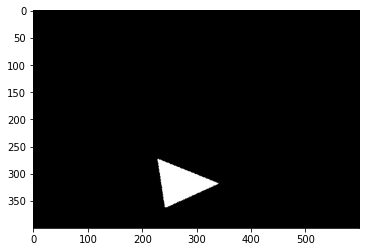

In [90]:
infer(model, train_data[0])

Image is square.


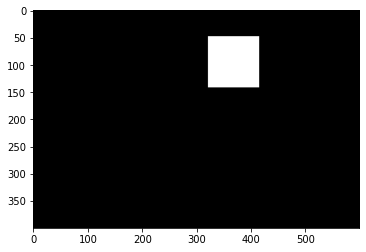

In [91]:
infer(model, train_data[100])

Image is circle.


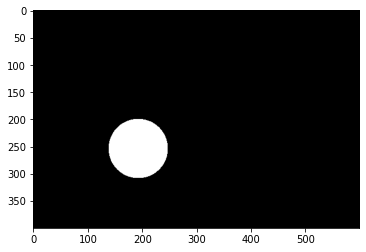

In [92]:
infer(model, train_data[170])

## Under the Hood

### Example 1

In [127]:
image, _ = train_data[150]

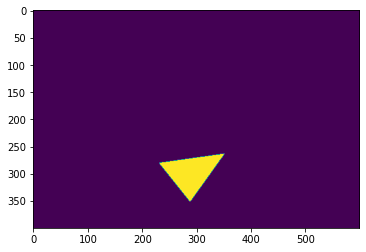

In [128]:
plt.imshow(image)

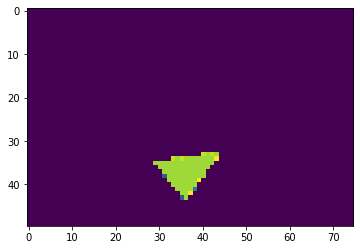

In [129]:
image = torch.FloatTensor(image)
input = image.unsqueeze(0)
input = input.squeeze(-1)
input = input.unsqueeze(1)

output_batch = F.relu(model.conv1(input))
output_batch = model.pool(output_batch)
output = output_batch[0]

plt.imshow(
    output.detach().numpy()[1]
)

plt.show()

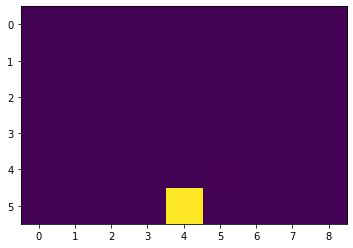

In [132]:
image = torch.FloatTensor(image)
input = image.unsqueeze(0)
input = input.squeeze(-1)
input = input.unsqueeze(1)

output_batch = F.relu(model.conv1(input))
output_batch = model.pool(output_batch)

output_batch = F.relu(model.conv2(output_batch))
output_batch = model.pool(output_batch)

output = output_batch[0]

plt.imshow(
    output.detach().numpy()[1]
)

plt.show()

### Example 2

In [133]:
image, _ = train_data[20]

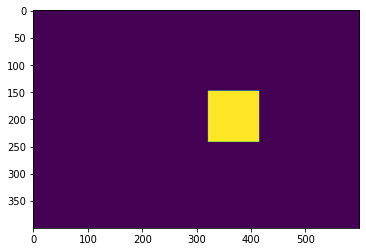

In [134]:
plt.imshow(image)

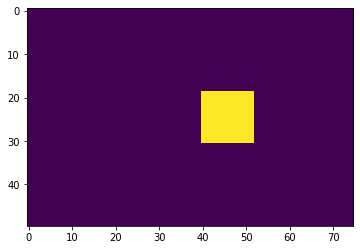

In [135]:
image = torch.FloatTensor(image)
input = image.unsqueeze(0)
input = input.squeeze(-1)
input = input.unsqueeze(1)

output_batch = F.relu(model.conv1(input))
output_batch = model.pool(output_batch)
output = output_batch[0]

plt.imshow(
    output.detach().numpy()[1]
)

plt.show()

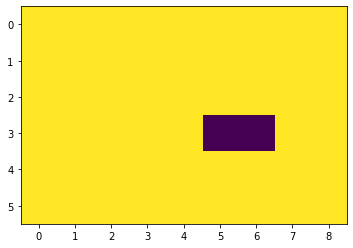

In [136]:
image = torch.FloatTensor(image)
input = image.unsqueeze(0)
input = input.squeeze(-1)
input = input.unsqueeze(1)

output_batch = F.relu(model.conv1(input))
output_batch = model.pool(output_batch)

output_batch = F.relu(model.conv2(output_batch))
output_batch = model.pool(output_batch)

output = output_batch[0]

plt.imshow(
    output.detach().numpy()[1]
)

plt.show()

### Example 3

In [137]:
image, _ = train_data[170]

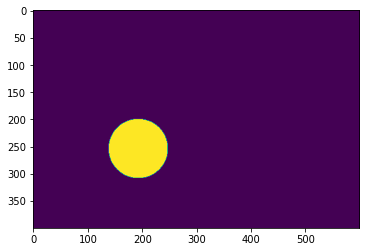

In [138]:
plt.imshow(image)

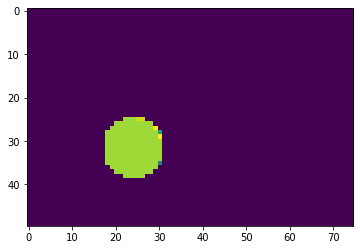

In [139]:
image = torch.FloatTensor(image)
input = image.unsqueeze(0)
input = input.squeeze(-1)
input = input.unsqueeze(1)

output_batch = F.relu(model.conv1(input))
output_batch = model.pool(output_batch)
output = output_batch[0]

plt.imshow(
    output.detach().numpy()[1]
)

plt.show()

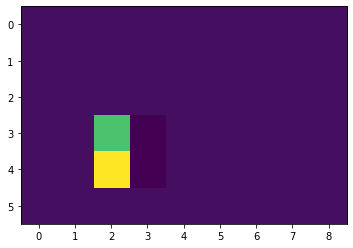

In [140]:
image = torch.FloatTensor(image)
input = image.unsqueeze(0)
input = input.squeeze(-1)
input = input.unsqueeze(1)

output_batch = F.relu(model.conv1(input))
output_batch = model.pool(output_batch)

output_batch = F.relu(model.conv2(output_batch))
output_batch = model.pool(output_batch)

output = output_batch[0]

plt.imshow(
    output.detach().numpy()[1]
)

plt.show()